Data Cleaning and Exploration

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

In [3]:
# Load the dataset
file_path = 'flows_ground_truth_merged_anonymized.csv'
df = pd.read_csv(file_path, delimiter=';')

In [4]:
# Display the first few rows and data info
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (109663, 112)
   flow_ID UA OS family UA OS major  UA OS minor  UA OS patch  UA OS patch minor                          start                            end  L3 PROTO  \
0     4313        Other         NaN          NaN          NaN                NaN  2020-07-16 06:44:07.608708000  2020-07-16 06:44:07.838529000         4   
1    14343        Other         NaN          NaN          NaN                NaN  2020-07-16 06:45:47.865065000  2020-07-16 06:45:47.913409000         4   
2    18958        Other         NaN          NaN          NaN                NaN  2020-07-16 06:46:30.471169000  2020-07-16 06:46:30.782348000         4   
3    21937      Windows          10          NaN          NaN                NaN  2020-07-16 06:47:41.565111000  2020-07-16 06:47:45.742005000         4   
4    14120        Other         NaN          NaN          NaN                NaN  2020-07-16 06:49:37.426397000  2020-07-16 06:49:37.640743000         4   

   L4 PROTO  BYTES A  PACKETS A   

In [5]:
# Basic schema overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109663 entries, 0 to 109662
Columns: 112 entries, flow_ID to Unnamed: 111
dtypes: float64(28), int64(63), object(21)
memory usage: 93.7+ MB


UA OS family
Other         42474
Windows       40349
Android       10290
iOS            8840
Mac OS X       5324
Linux          1589
Ubuntu          653
Fedora           88
Chrome OS        53
Symbian OS        1
Slackware         1
Linux Mint        1
Name: count, dtype: int64


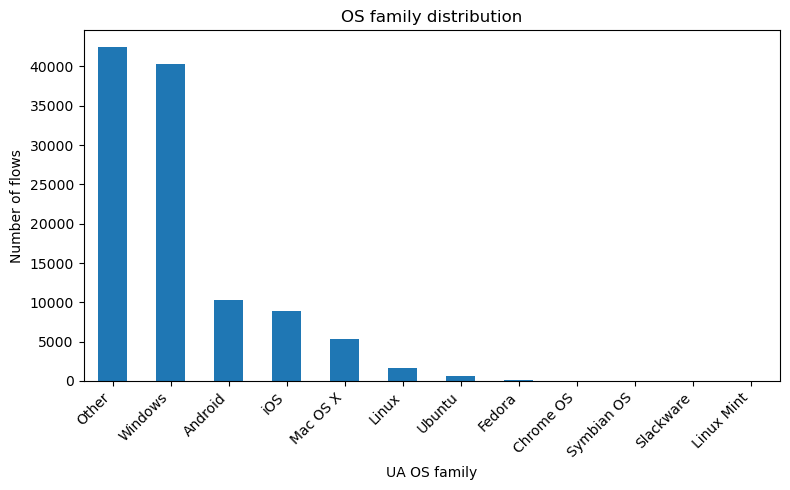

In [6]:
os_counts = df["UA OS family"].value_counts().sort_values(ascending=False)
print(os_counts)

plt.figure(figsize=(8, 5))
os_counts.plot(kind="bar")
plt.title("OS family distribution")
plt.ylabel("Number of flows")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [7]:
# Many NPM_* fields use 4294967295 as "missing" sentinel, convert to NaN
sentinel = 4294967295
print("Sentinel occurrences before:", (df == sentinel).sum().sort_values(ascending=False).head(15))

df = df.replace(sentinel, np.nan)

print("\nSentinel occurrences after replacement:",
      (df == sentinel).sum().sort_values(ascending=False).head(5))


Sentinel occurrences before: NPM_SERVER_RESPONSE_TIME    19460
NPM_JITTER_MIN_B            10069
NPM_JITTER_AVG_B            10069
NPM_JITTER_DEV_B            10069
NPM_JITTER_MAX_B            10069
NPM_DELAY_MIN_B              4718
NPM_DELAY_DEV_B              4718
NPM_DELAY_AVG_B              4718
NPM_DELAY_MAX_B              4718
NPM_JITTER_AVG_A               87
NPM_JITTER_MAX_A               87
NPM_JITTER_DEV_A               87
NPM_JITTER_MIN_A               87
NPM_DELAY_DEV_A                 2
NPM_DELAY_MAX_A                 2
dtype: int64

Sentinel occurrences after replacement: flow_ID         0
UA OS family    0
UA OS major     0
UA OS minor     0
UA OS patch     0
dtype: int64


In [8]:
# Fraction of missing values per column
na_frac = df.isna().mean().sort_values(ascending=False)

print("Top 20 columns by missing fraction:")
print(na_frac.head(20))

print("\nBottom 20 columns by missing fraction:")
print(na_frac.tail(20))


Top 20 columns by missing fraction:
UA OS patch minor                  1.000000
ICMP TYPE                          1.000000
TLS_SUBJECT_ON                     1.000000
Unnamed: 111                       1.000000
TLS_ISSUER_CN                      1.000000
TLS_SUBJECT_CN                     1.000000
TLS_ALPN                           0.995048
UA OS patch                        0.852402
UA OS minor                        0.814249
tcpTimestampFirstPacketbackward    0.521379
UA OS major                        0.413859
tcpTimestampFirstPacketforward     0.397810
NPM_SERVER_RESPONSE_TIME           0.177453
TLS_EXTENSION_LENGTHS              0.093815
TLS_SERVER_SESSION_ID              0.093815
TLS_CIPHER_SUITE                   0.093815
TLS_CLIENT_RANDOM                  0.093815
TLS_SNI                            0.093815
TLS_SETUP_TIME                     0.093815
TLS_CONTENT_TYPE                   0.093815
dtype: float64

Bottom 20 columns by missing fraction:
NPM_DELAY_HISTOGRAM_4_B      

In [9]:
df_clean = df.copy()

# ---------------------------
# 1) Drop label-leaking OS version fields
# ---------------------------
leakage_cols = [
    "UA OS major",
    "UA OS minor",
    "UA OS patch",
    "UA OS patch minor",
]

# ---------------------------
# 2) Drop identifiers / low-level metadata
# ---------------------------
id_cols = [
    "flow_ID",
    "start",
    "end",
    "SRC IP",
    "DST IP",
    "SRC port",
    "DST port",
]

# ---------------------------
# 3) Drop raw HTTP / URL fields
# ---------------------------
http_cols = [
    "HTTP Request Method",
    "HTTP Request Host",
    "HTTP Response Code",
    "URL",
]

# ---------------------------
# 4) Drop noisy TLS fields (randoms, session IDs, full SNI, cert details)
# ---------------------------
tls_noise_cols = [
    "TLS_SNI",
    "TLS_SERVER_RANDOM",
    "TLS_SERVER_SESSION_ID",
    "TLS_CLIENT_RANDOM",
    "TLS_CLIENT_SESSION_ID",
    "TLS_ISSUER_CN",
    "TLS_SUBJECT_CN",
    "TLS_SUBJECT_ON",
    "TLS_VALIDITY_NOT_BEFORE",
    "TLS_VALIDITY_NOT_AFTER",
    "TLS_SIGNATURE_ALG",
    "TLS_PUBLIC_KEY_ALG",
    "TLS_PUBLIC_KEY_LENGTH",
]

# ---------------------------
# 5) Drop fully-unused / strongly uninformative protocol flags
# ---------------------------
other_junk_cols = [
    "Unnamed: 111",   # artifact
    "ICMP TYPE",      # all NaN
    "L3 PROTO",       # constant
    "L4 PROTO",       # constant
]

to_drop = leakage_cols + id_cols + http_cols + tls_noise_cols + other_junk_cols
to_drop = [c for c in to_drop if c in df_clean.columns]

print("Dropping columns:", to_drop)

df_clean = df_clean.drop(columns=to_drop)
print("Shape after manual drops:", df_clean.shape)


Dropping columns: ['UA OS major', 'UA OS minor', 'UA OS patch', 'UA OS patch minor', 'flow_ID', 'start', 'end', 'SRC IP', 'DST IP', 'SRC port', 'DST port', 'HTTP Request Host', 'URL', 'TLS_SNI', 'TLS_SERVER_RANDOM', 'TLS_SERVER_SESSION_ID', 'TLS_CLIENT_RANDOM', 'TLS_CLIENT_SESSION_ID', 'TLS_ISSUER_CN', 'TLS_SUBJECT_CN', 'TLS_SUBJECT_ON', 'TLS_VALIDITY_NOT_BEFORE', 'TLS_VALIDITY_NOT_AFTER', 'TLS_SIGNATURE_ALG', 'TLS_PUBLIC_KEY_ALG', 'TLS_PUBLIC_KEY_LENGTH', 'Unnamed: 111', 'ICMP TYPE', 'L3 PROTO', 'L4 PROTO']
Shape after manual drops: (109663, 82)


In [10]:
import numpy as np

# Start from the original column
col = "UA OS family"

# 1) Merge Mac OS X + iOS  →  iOS
df_clean[col] = df_clean[col].replace({"Mac OS X": "iOS"})

# 2) Merge all Linux systems  →  Linux
linux_families = ["Linux", "Ubuntu", "Fedora", "Slackware", "Linux Mint"]
df_clean[col] = df_clean[col].replace({os_name: "Linux" for os_name in linux_families})

# 3) Everything else (except major families)  →  Others
major_keep = {"Windows", "Android", "iOS", "Linux", "Other"}  # keep these as-is
df_clean[col] = np.where(df_clean[col].isin(major_keep), df_clean[col], "Other")

# Check new distribution
print(df_clean[col].value_counts())


UA OS family
Other      42528
Windows    40349
iOS        14164
Android    10290
Linux       2332
Name: count, dtype: int64


In [11]:
nunique = df_clean.nunique(dropna=True)
constant_cols = nunique[nunique <= 1].index.tolist()

print("Constant or all-null columns to drop:", constant_cols)

df_clean = df_clean.drop(columns=constant_cols)
print("Shape after dropping constant/all-null cols:", df_clean.shape)


Constant or all-null columns to drop: ['NPM_DELAY_HISTOGRAM_2_A', 'NPM_DELAY_HISTOGRAM_3_A', 'NPM_DELAY_HISTOGRAM_4_A', 'NPM_DELAY_HISTOGRAM_5_A', 'NPM_DELAY_HISTOGRAM_6_A', 'NPM_DELAY_HISTOGRAM_7_A', 'NPM_DELAY_HISTOGRAM_2_B', 'NPM_DELAY_HISTOGRAM_3_B', 'NPM_DELAY_HISTOGRAM_4_B', 'NPM_DELAY_HISTOGRAM_5_B', 'NPM_DELAY_HISTOGRAM_6_B', 'NPM_DELAY_HISTOGRAM_7_B', 'maximumTTLbackward', 'IPv4DontFragmentbackward', 'tcpOptionWindowScalebackward', 'tcpOptionMaximumSegmentSizebackward', 'synAckFlag']
Shape after dropping constant/all-null cols: (109663, 65)


In [12]:
print("Remaining columns:", len(df_clean.columns))
df_clean.columns.to_list()


Remaining columns: 65


['UA OS family',
 'BYTES A',
 'PACKETS A',
 'TCP flags A',
 'TCP SYN Size',
 'TCP Win Size',
 'TCP SYN TTL',
 'IP ToS',
 'NPM_CLIENT_NETWORK_TIME',
 'NPM_SERVER_NETWORK_TIME',
 'NPM_SERVER_RESPONSE_TIME',
 'NPM_ROUND_TRIP_TIME',
 'NPM_RESPONSE_TIMEOUTS_A',
 'NPM_RESPONSE_TIMEOUTS_B',
 'NPM_TCP_RETRANSMISSION_A',
 'NPM_TCP_RETRANSMISSION_B',
 'NPM_TCP_OUT_OF_ORDER_A',
 'NPM_TCP_OUT_OF_ORDER_B',
 'NPM_JITTER_DEV_A',
 'NPM_JITTER_AVG_A',
 'NPM_JITTER_MIN_A',
 'NPM_JITTER_MAX_A',
 'NPM_DELAY_DEV_A',
 'NPM_DELAY_AVG_A',
 'NPM_DELAY_MIN_A',
 'NPM_DELAY_MAX_A',
 'NPM_DELAY_HISTOGRAM_1_A',
 'NPM_JITTER_DEV_B',
 'NPM_JITTER_AVG_B',
 'NPM_JITTER_MIN_B',
 'NPM_JITTER_MAX_B',
 'NPM_DELAY_DEV_B',
 'NPM_DELAY_AVG_B',
 'NPM_DELAY_MIN_B',
 'NPM_DELAY_MAX_B',
 'NPM_DELAY_HISTOGRAM_1_B',
 'TLS_CONTENT_TYPE',
 'TLS_HANDSHAKE_TYPE',
 'TLS_SETUP_TIME',
 'TLS_SERVER_VERSION',
 'TLS_CIPHER_SUITE',
 'TLS_ALPN',
 'TLS_SNI_LENGTH',
 'TLS_CLIENT_VERSION',
 'TLS_CIPHER_SUITES',
 'TLS_EXTENSION_TYPES',
 'TLS_EXTEN

In [13]:
# Check OS family distribution after cleaning (should be unchanged)
print(df_clean["UA OS family"].value_counts())


UA OS family
Other      42528
Windows    40349
iOS        14164
Android    10290
Linux       2332
Name: count, dtype: int64


Feature counts: {'TCP': 10, 'TLS': 15, 'NPM': 28}

TCP (10): ['BYTES A', 'PACKETS A', 'TCP flags A', 'TCP SYN Size', 'TCP Win Size', 'TCP SYN TTL', 'IP ToS', 'maximumTTLforward', 'packetTotalCountforward', 'packetTotalCountbackward']

TLS (15): ['TLS_CONTENT_TYPE', 'TLS_HANDSHAKE_TYPE', 'TLS_SETUP_TIME', 'TLS_SERVER_VERSION', 'TLS_CIPHER_SUITE', 'TLS_ALPN', 'TLS_SNI_LENGTH', 'TLS_CLIENT_VERSION', 'TLS_CIPHER_SUITES', 'TLS_EXTENSION_TYPES', 'TLS_EXTENSION_LENGTHS', 'TLS_ELLIPTIC_CURVES', 'TLS_EC_POINT_FORMATS', 'TLS_CLIENT_KEY_LENGTH', 'TLS_JA3_FINGERPRINT']

NPM (28): ['NPM_CLIENT_NETWORK_TIME', 'NPM_SERVER_NETWORK_TIME', 'NPM_SERVER_RESPONSE_TIME', 'NPM_ROUND_TRIP_TIME', 'NPM_RESPONSE_TIMEOUTS_A', 'NPM_RESPONSE_TIMEOUTS_B', 'NPM_TCP_RETRANSMISSION_A', 'NPM_TCP_RETRANSMISSION_B', 'NPM_TCP_OUT_OF_ORDER_A', 'NPM_TCP_OUT_OF_ORDER_B', 'NPM_JITTER_DEV_A', 'NPM_JITTER_AVG_A', 'NPM_JITTER_MIN_A', 'NPM_JITTER_MAX_A', 'NPM_DELAY_DEV_A', 'NPM_DELAY_AVG_A', 'NPM_DELAY_MIN_A', 'NPM_DELAY_MAX_A', '

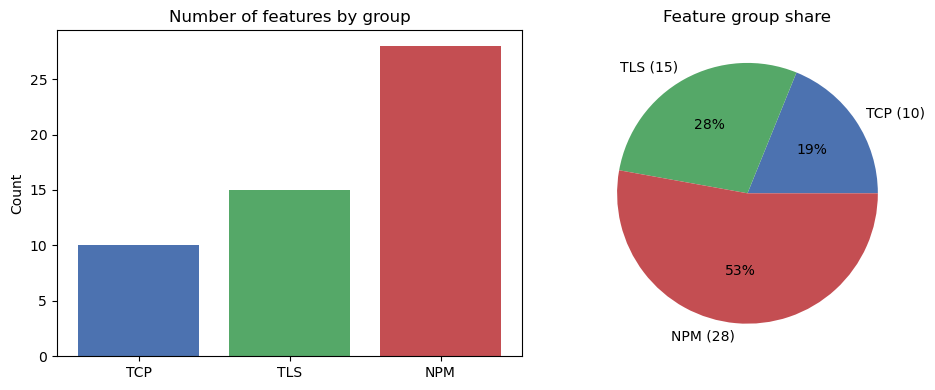

In [16]:
# Feature-group breakdown (TCP / TLS / NPM)
try:
    groups = {"TCP": tcp_ip_features, "TLS": tls_features, "NPM": npm_features}
except NameError:
    # fallback: infer groups from column name patterns
    groups = {
        "TCP": [c for c in df_clean.columns if c in ["BYTES A","PACKETS A","TCP flags A","TCP SYN Size","TCP Win Size","TCP SYN TTL","IP ToS","maximumTTLforward","packetTotalCountforward","packetTotalCountbackward"]],
        "TLS": [c for c in df_clean.columns if c.startswith("TLS_")],
        "NPM": [c for c in df_clean.columns if c.startswith("NPM_")],
    }

present = {k: [c for c in cols if c in df_clean.columns] for k, cols in groups.items()}
counts = {k: len(v) for k, v in present.items()}

print("Feature counts:", counts)
for k, v in present.items():
    print(f"\n{k} ({len(v)}): {v}")

# Simple bar + pie plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = list(counts.keys())
values = [counts[k] for k in labels]

# bar
axes[0].bar(labels, values, color=["#4C72B0", "#55A868", "#C44E52"])
axes[0].set_title("Number of features by group")
axes[0].set_ylabel("Count")

# pie
axes[1].pie(values, labels=[f"{l} ({c})" for l, c in zip(labels, values)], autopct="%1.0f%%", colors=["#4C72B0", "#55A868", "#C44E52"])
axes[1].set_title("Feature group share")

plt.tight_layout()
plt.show()

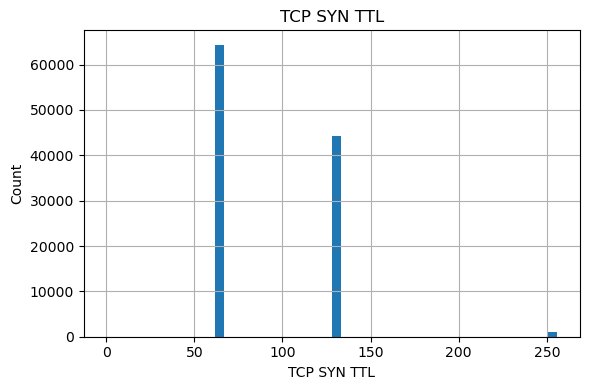

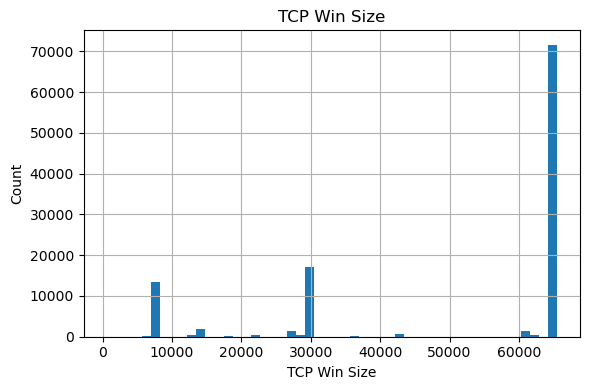

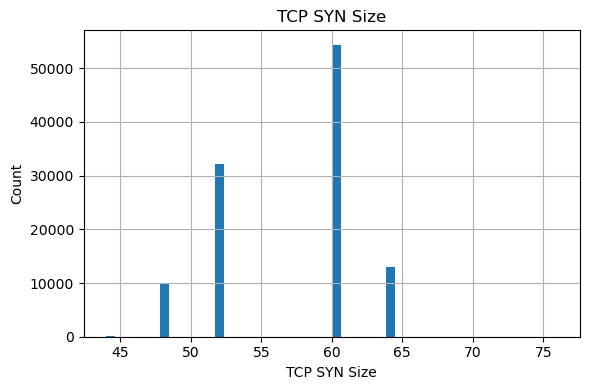

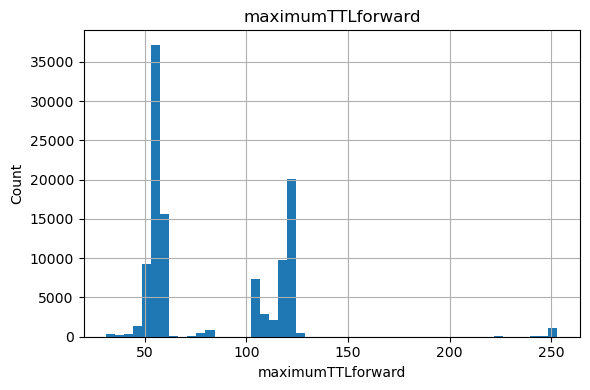

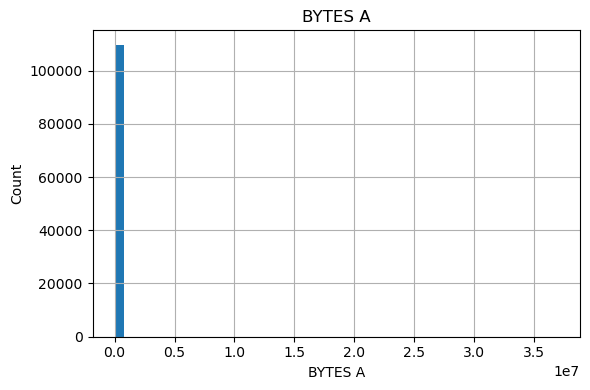

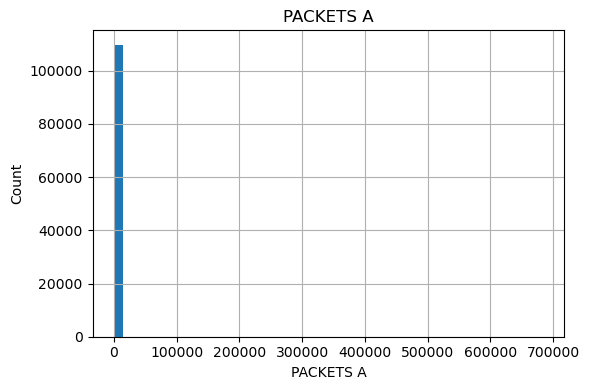

In [27]:
key_num_cols = [
    "TCP SYN TTL",
    "TCP Win Size",
    "TCP SYN Size",
    "maximumTTLforward",
    "BYTES A",
    "PACKETS A",
]

for col in key_num_cols:
    if col in df_clean.columns:
        plt.figure(figsize=(6, 4))
        df_clean[col].hist(bins=50)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{col} not in df_clean, skipping.")


In [28]:
group_cols = [c for c in key_num_cols if c in df_clean.columns]

os_means = df_clean.groupby("UA OS family")[group_cols].mean().round(2)
os_means


,TCP SYN TTL,TCP Win Size,TCP SYN Size,maximumTTLforward,BYTES A,PACKETS A
UA OS family,,,,,,
Android,77.27,62565.23,59.79,68.66,5599.42,73.62
Linux,69.90,49060.89,59.56,61.67,5215.55,51.31
Other,80.38,43235.10,57.57,68.38,3855.65,59.78
Windows,116.03,49846.64,53.34,108.33,5198.92,51.17
iOS,70.47,61705.55,63.36,62.09,5315.29,62.14


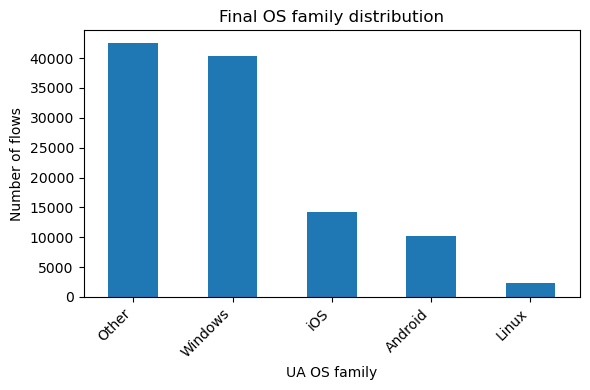

In [32]:
os_counts = df_clean["UA OS family"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6,4))
os_counts.plot(kind="bar")
plt.title("Final OS family distribution")
plt.ylabel("Number of flows")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


<Figure size 700x400 with 0 Axes>

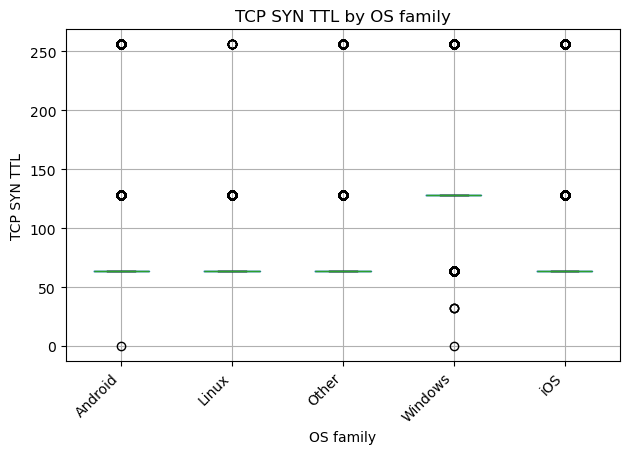

<Figure size 700x400 with 0 Axes>

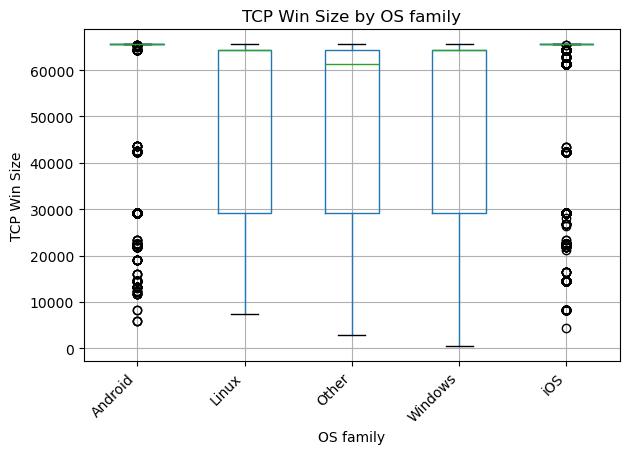

<Figure size 700x400 with 0 Axes>

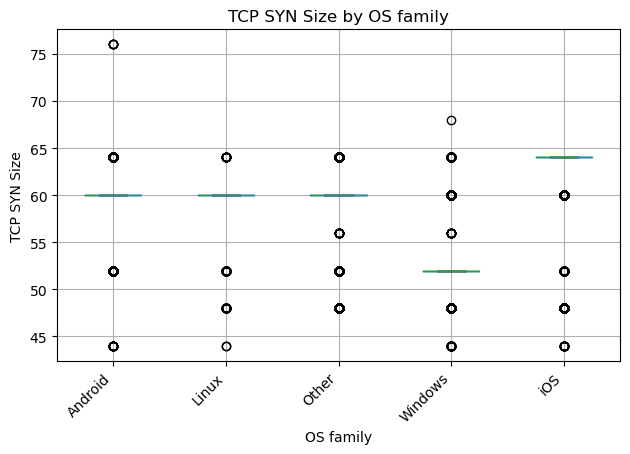

In [33]:
core_cols = ["TCP SYN TTL", "TCP Win Size", "TCP SYN Size"]

for col in core_cols:
    if col not in df_clean.columns:
        continue
    plt.figure(figsize=(7,4))
    df_clean.boxplot(column=col, by="UA OS family")
    plt.title(f"{col} by OS family")
    plt.suptitle("")  # remove default pandas title
    plt.xlabel("OS family")
    plt.ylabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [29]:
target_col = "UA OS family"

# Core TCP/IP / flow features
tcp_ip_features = [
    "BYTES A",
    "PACKETS A",
    "TCP flags A",
    "TCP SYN Size",
    "TCP Win Size",
    "TCP SYN TTL",
    "IP ToS",
    "IPv4DontFragmentforward",
    "maximumTTLforward",
    "tcpTimestampFirstPacketforward",
    "tcpOptionWindowScaleforward",
    "tcpOptionSelectiveAckPermittedforward",
    "tcpOptionMaximumSegmentSizeforward",
    "tcpOptionNoOperationforward",
    "packetTotalCountforward",
    "packetTotalCountbackward",
    "flowDirection",
    "flowEndReason",
]

# NPM / behavior features (subset; you can adjust later)
npm_features = [
    "NPM_CLIENT_NETWORK_TIME",
    "NPM_SERVER_NETWORK_TIME",
    "NPM_SERVER_RESPONSE_TIME",
    "NPM_ROUND_TRIP_TIME",
    "NPM_RESPONSE_TIMEOUTS_A",
    "NPM_RESPONSE_TIMEOUTS_B",
    "NPM_TCP_RETRANSMISSION_A",
    "NPM_TCP_RETRANSMISSION_B",
    "NPM_TCP_OUT_OF_ORDER_A",
    "NPM_TCP_OUT_OF_ORDER_B",
    "NPM_JITTER_DEV_A",
    "NPM_JITTER_AVG_A",
    "NPM_JITTER_DEV_B",
    "NPM_JITTER_AVG_B",
    "NPM_DELAY_AVG_A",
    "NPM_DELAY_AVG_B",
    "NPM_DELAY_HISTOGRAM_1_A",
    "NPM_DELAY_HISTOGRAM_1_B",
]

# TLS handshake / JA3 features (client-focused)
tls_features = [
    "TLS_CONTENT_TYPE",
    "TLS_HANDSHAKE_TYPE",
    "TLS_SETUP_TIME",
    "TLS_SERVER_VERSION",
    "TLS_CLIENT_VERSION",
    "TLS_CIPHER_SUITE",      # server-chosen
    "TLS_ALPN",
    "TLS_SNI_LENGTH",
    "TLS_CIPHER_SUITES",     # client-offered list
    "TLS_EXTENSION_TYPES",
    "TLS_EXTENSION_LENGTHS",
    "TLS_ELLIPTIC_CURVES",
    "TLS_EC_POINT_FORMATS",
    "TLS_CLIENT_KEY_LENGTH",
    "TLS_JA3_FINGERPRINT",
]

# Only keep features that actually exist after cleaning
all_feature_cols = tcp_ip_features + npm_features + tls_features
all_feature_cols = [c for c in all_feature_cols if c in df_clean.columns]

print("Number of selected feature columns:", len(all_feature_cols))
print("Selected feature columns:")
print(all_feature_cols)


Number of selected feature columns: 51
Selected feature columns:
['BYTES A', 'PACKETS A', 'TCP flags A', 'TCP SYN Size', 'TCP Win Size', 'TCP SYN TTL', 'IP ToS', 'IPv4DontFragmentforward', 'maximumTTLforward', 'tcpTimestampFirstPacketforward', 'tcpOptionWindowScaleforward', 'tcpOptionSelectiveAckPermittedforward', 'tcpOptionMaximumSegmentSizeforward', 'tcpOptionNoOperationforward', 'packetTotalCountforward', 'packetTotalCountbackward', 'flowDirection', 'flowEndReason', 'NPM_CLIENT_NETWORK_TIME', 'NPM_SERVER_NETWORK_TIME', 'NPM_SERVER_RESPONSE_TIME', 'NPM_ROUND_TRIP_TIME', 'NPM_RESPONSE_TIMEOUTS_A', 'NPM_RESPONSE_TIMEOUTS_B', 'NPM_TCP_RETRANSMISSION_A', 'NPM_TCP_RETRANSMISSION_B', 'NPM_TCP_OUT_OF_ORDER_A', 'NPM_TCP_OUT_OF_ORDER_B', 'NPM_JITTER_DEV_A', 'NPM_JITTER_AVG_A', 'NPM_JITTER_DEV_B', 'NPM_JITTER_AVG_B', 'NPM_DELAY_AVG_A', 'NPM_DELAY_AVG_B', 'NPM_DELAY_HISTOGRAM_1_A', 'NPM_DELAY_HISTOGRAM_1_B', 'TLS_CONTENT_TYPE', 'TLS_HANDSHAKE_TYPE', 'TLS_SETUP_TIME', 'TLS_SERVER_VERSION', 'TLS_

In [30]:
df_ml = df_clean[[target_col] + all_feature_cols].copy()

print("ML-ready dataset shape:", df_ml.shape)
df_ml.head()


ML-ready dataset shape: (109663, 52)


,UA OS family,BYTES A,PACKETS A,TCP flags A,TCP SYN Size,TCP Win Size,TCP SYN TTL,IP ToS,IPv4DontFragmentforward,maximumTTLforward,tcpTimestampFirstPacketforward,tcpOptionWindowScaleforward,tcpOptionSelectiveAckPermittedforward,tcpOptionMaximumSegmentSizeforward,tcpOptionNoOperationforward,packetTotalCountforward,packetTotalCountbackward,flowDirection,flowEndReason,NPM_CLIENT_NETWORK_TIME,NPM_SERVER_NETWORK_TIME,NPM_SERVER_RESPONSE_TIME,NPM_ROUND_TRIP_TIME,NPM_RESPONSE_TIMEOUTS_A,NPM_RESPONSE_TIMEOUTS_B,NPM_TCP_RETRANSMISSION_A,NPM_TCP_RETRANSMISSION_B,NPM_TCP_OUT_OF_ORDER_A,NPM_TCP_OUT_OF_ORDER_B,NPM_JITTER_DEV_A,NPM_JITTER_AVG_A,NPM_JITTER_DEV_B,NPM_JITTER_AVG_B,NPM_DELAY_AVG_A,NPM_DELAY_AVG_B,NPM_DELAY_HISTOGRAM_1_A,NPM_DELAY_HISTOGRAM_1_B,TLS_CONTENT_TYPE,TLS_HANDSHAKE_TYPE,TLS_SETUP_TIME,TLS_SERVER_VERSION,TLS_CLIENT_VERSION,TLS_CIPHER_SUITE,TLS_ALPN,TLS_SNI_LENGTH,TLS_CIPHER_SUITES,TLS_EXTENSION_TYPES,TLS_EXTENSION_LENGTHS,TLS_ELLIPTIC_CURVES,TLS_EC_POINT_FORMATS,TLS_CLIENT_KEY_LENGTH,TLS_JA3_FINGERPRINT
0,Other,696,6,---AP-SF,60.0,64240.0,64,0,1,57,3.587552e+09,10.0,1,1460.0,1,6,4,1,1,108651,1156,9747.0,109807,0,0,0,0,0,0,0.0,109746.0,NaN,NaN,54934.0,119615.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Other,489,4,---AP-SF,60.0,29200.0,64,0,1,58,2.330306e+09,7.0,1,1460.0,1,4,3,0,1,22239,960,1416.0,23199,0,0,0,0,0,0,0.0,23113.0,NaN,NaN,11642.0,NaN,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Other,587,5,---AP-SF,60.0,64240.0,64,0,1,57,5.437506e+08,10.0,1,1460.0,1,5,4,1,1,101405,999,2819.0,102404,0,0,0,0,0,0,0.0,28883.0,NaN,NaN,87962.0,178744.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Windows,1825,12,---AP-SF,52.0,64240.0,128,48,1,119,NaN,8.0,1,1420.0,1,12,12,1,1,3043536,1072,9987.0,3044608,2,1,2,1,1,2,14059.0,462850.0,9086.0,615785.0,400966.0,534568.0,6,5,15.0,8194.0,83579.0,0.0,771.0,0.0,NaN,7.0,2CC02BC030C02FC024C023C028C027C0,000005000A000B000D002300170001FFFFFFFFFFFFFFFF...,0C000500080002001400000000000100FFFFFFFFFFFFFF...,1D0017001800,00FFFFFF,528.0,A0E9F5D64349FB13191BC781F81F42E1
4,Other,605,5,---AP-SF,60.0,64240.0,64,0,1,57,3.895507e+09,10.0,1,1460.0,1,5,3,1,1,103317,1229,3260.0,104546,0,0,0,0,0,0,0.0,104520.0,NaN,NaN,52286.0,NaN,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Save ML-ready dataset (semicolon-separated like original)
ML_READY_PATH = "flows_ml_ready.csv"
df_ml.to_csv(ML_READY_PATH, sep=";", index=False)
print(f"ML-ready dataset saved to: {ML_READY_PATH}")


ML-ready dataset saved to: flows_ml_ready.csv
